https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
print(check_output(['ls','../Quora_Question_pairs_data/']).decode('utf-8'))

df = pd.read_csv('../Quora_Question_pairs_data/train.csv').fillna('')
df.head()

sample_submission.csv.zip
test.csv
test.csv.zip
train.csv
train.csv.zip



,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.shape

(404290, 6)

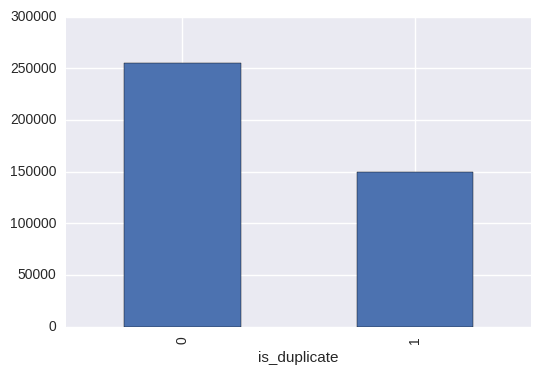

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

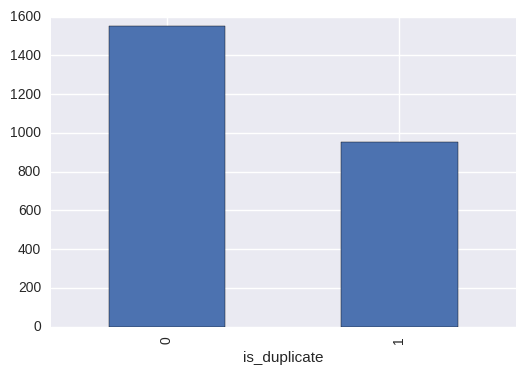

In [6]:
dfs = df[0:2500]
dfs.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
dfq1, dfq2 = dfs[['qid1','question1']], dfs[['qid2','question2']]
dfq1.columns = ['qid1','question']
dfq2.columns = ['qid2','question']

dfqa = pd.concat((dfq1, dfq2),axis=0).fillna('')
nrows_for_q1 = dfqa.shape[0] / 2.
dfqa.shape

(5000, 3)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<type 'numpy.float64'>'
	with 31365 stored elements in Compressed Sparse Row format>

In [9]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<type 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

In [10]:
dfqa[::2].shape

(2500, 3)

In [11]:
diff_encodings.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5).fit_transform(diff_encodings.toarray())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466567
[t-SNE] Iteration 25: error = 1.6895078, gradient norm = 0.0104412
[t-SNE] Iteration 50: error = 1.6089255, gradient norm = 0.0101917
[t-SNE] Iteration 75: error = 1.3087113, gradient norm = 0.0033242
[t-SNE] Iteration 100: error = 1.2537448, gradient norm = 0.0044264
[t-SNE] Error after 100 iterations with early exaggeration: 1.253745
[t-SNE] Iteration 125: error = 1.1550491, gradient norm = 0.0009702
[t-SNE] Iteration 125: gradient norm 0.000970. Finished.
[t-SNE] Error after 125 iterations: 1.155049


In [13]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color=dfs['is_duplicate'].values,
        colorscale='Portland',
        colorbar=dict(title='duplicate'),
        line=dict(color='rgb(255,255,255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800,title='test')
fig=dict(data=data,layout=layout)
py.iplot(fig,filename='3DBubble')

In [14]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(' ')))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' '))) #set
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0 * len(w1 & w2) / float(len(w1) + len(w2))

df['words_share'] = df.apply(normalized_word_share,axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,words_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


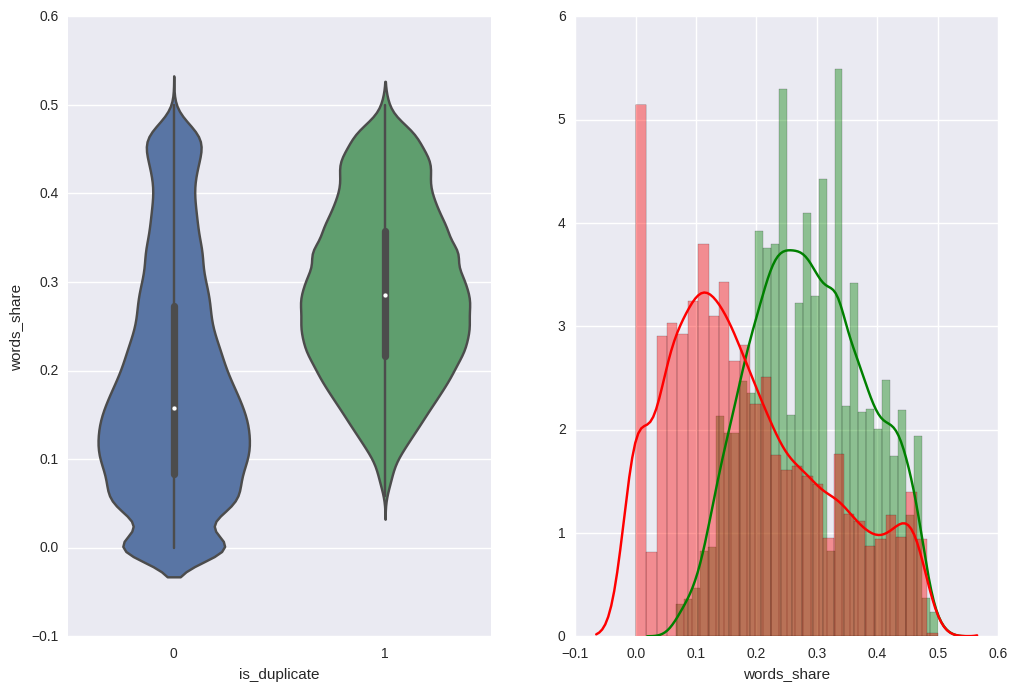

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='words_share',data=df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['words_share'][0:10000],color='green')
sns.distplot(df[df['is_duplicate']==0.0]['words_share'][0:10000],color='red')

In [16]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y=df_subsampled['q2len'].values,
    x=df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size=df_subsampled['words_share'].values * 60,
        color=df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar=dict(title='duplicate')
    ),
    text = np.round(df_subsampled['words_share'].values, decimals=2)
)
data = [trace]

layout=go.Layout(
    autosize=True,
    title = 'Scatter plot of character lengths of question one and two',
    hovermode='closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Question 2 length',
        ticklen=5,
        gridwidth=2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend=False
)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatterWords')

In [17]:
from IPython.display import display,HTML

df_subsampled['q_n_words_avg'] = np.round((df_subsampled['q1_n_words'] + df_subsampled['q2_n_words'])/2.).astype(int)
print(df_subsampled['q_n_words_avg'].max())
df_subsampled = df_subsampled[df_subsampled['q_n_words_avg'] < 20]
df_subsampled.head()

39


/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,words_share,q_n_words_avg
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783,13
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000,10
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667,12
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000,10
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000,10


In [23]:
word_lens = sorted(list(df_subsampled['q_n_words_avg'].unique()))
#make figure
figure = {
    'data':[],
    'layout': {
        'title':'Scatter plot of char lengths of Q1 and Q2(size ~ word share similarity)'
    },
    'frames':[]
}

#fill in most of layout
figure['layout']['xaxis'] = {'range':[0,200],'title':'Q1 length'}
figure['layout']['yaxis'] = {
    'range':[0,200],
    'title':'Q2 length'
}
figure['layout']['hovermode'] = 'closest'
figure['layout']['updatemenus'] = [
    {
        'buttons':[
            {
                'args':[None,{'frame':{'duration':300,'radraw':False},
                             'fromcurrent':True,'transition':{'duration':300,'easing':'quadratic-in-out'}}],
                'label':'Play',
                'method':'animate'
            },
            {'args':[[None],{'frame':{'duration':0,'redraw':False},'mode':'immediate',
                            'transition':{'duration':0}}],
            'label':'Pause',
            'method':'animate'
            }
        ],
        'direction':'left',
        'pad':{'r':10,'t':87},
        'showactive':False,
        'type':'buttons',
        'x':0.1,
        'xanchor':'right',
        'yanchor':'top'
    }
]

sliders_dict = {
    'active':0,
    'yanchor':'top',
    'xanchor':'left',
    'currentvalue':{
        'font':{'size':20},
        'prefix':'Avg. number of words in both questions',
        'visible':True,
        'xanchor':'right'
        
    },
    'transition':{'duration':300,'easing':'cubic-in-out'},
    'pad':{'b':10,'t':50},
    'len':0.9,
    'x':0.1,
    'y':0,
    'steps':[]
}

#make data
word_len = word_lens[0]
dff = df_subsampled[df_subsampled['q_n_words_avg']==word_len]
data_dict = {
    'x':list(dff['q1len']),
    'y':list(dff['q2len']),
    'mode':'markers',
    'text':list(dff['is_duplicate']),
    'marker':{
        'sizemode':'area',
        'colorscale':'Portland',
        'size':dff['words_share'].values * 120,
        'color':dff['is_duplicate'].values,
        'colorbar':dict(title='duplicate')
    },
    'name':'some name'
}
figure['data'].append(data_dict)

#make frames
for word_len in word_lens:
    frame = {'data':[],'name':str(word_len)}
    dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]
    
    data_dict = {
        'x':list(dff['q1len']),
        'y':list(dff['q2len']),
        'mode':'markers',
        'text':list(dff['is_duplicate']),
        'marker':{
            'sizemode':'area',
            'colorscale':'Portland',
            'size':dff['words_share'].values * 120,
            'color':dff['is_duplicate'].values,
                'colorbar':dict(title='duplicate')
        },
        'name':'some name'
    }
    frame['data'].append(data_dict)
    
    figure['frames'].append(frame)
    slider_step = {'args':[
            [word_len],
            {
                'frame':{'duration':300,'redraw':False},
                'mode':'immediate',
                'transition':{'duration':300}
            }
        ],
        'label':word_len,
        'method':'animate'}
    sliders_dict['steps'].append(slider_step)

figure['layout']['sliders'] = [slider_step]

figure['layout']['sliders'] = [sliders_dict]

py.iplot(figure)
            

PlotlyError: Invalid 'figure_or_data' argument. Plotly will not be able to properly parse the resulting JSON. If you want to send this 'figure_or_data' to Plotly anyway (not recommended), you can set 'validate=False' as a plot option.
Here's why you're seeing this error:

'frames' is not allowed in 'figure'

Path To Error: ['frames']

Valid attributes for 'figure' at path [] under parents []:

    ['layout', 'data']

Run `<figure-object>.help('attribute')` on any of the above.
'<figure-object>' is the object at []

In [29]:
word_lens = sorted(list(df_subsampled['q_n_words_avg'].unique()))
# make figure
figure = {
    'data': [],
    'layout': {
        'title': 'Scatter plot of char lenghts of Q1 and Q2 (size ~ word share similarity)',
    },
    'frames': []#,
    #'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0, 200], 'title': 'Q1 length'}
figure['layout']['yaxis'] = {
    'range': [0, 200],
    'title': 'Q2 length'#,
    #'type': 'log'
}
figure['layout']['hovermode'] = 'closest'

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Avg. number of words in both questions:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
word_len = word_lens[0]
dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]
data_dict = {
    'x': list(dff['q1len']),
    'y': list(dff['q2len']),
    'mode': 'markers',
    'text': list(dff['is_duplicate']),
    'marker': {
        'sizemode': 'area',
        #'sizeref': 200000,
        'colorscale': 'Portland',
        'size': dff['words_share'].values * 120,
        'color': dff['is_duplicate'].values,
        'colorbar': dict(title = 'duplicate')
    },
    'name': 'some name'
}
figure['data'].append(data_dict)

# make frames
for word_len in word_lens:
    frame = {'data': [], 'name': str(word_len)}
    dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]

    data_dict = {
        'x': list(dff['q1len']),
        'y': list(dff['q2len']),
        'mode': 'markers',
        'text': list(dff['is_duplicate']),
        'marker': {
            'sizemode': 'area',
            #'sizeref': 200000,
            'size': dff['words_share'].values * 120,
            'colorscale': 'Portland',
            'color': dff['is_duplicate'].values,
            'colorbar': dict(title = 'duplicate')
        },
        'name': 'some name'
    }
    frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [word_len],
        {
            'frame': {'duration': 300, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 300}
        }
     ],
     'label': word_len,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]

py.iplot(figure)


PlotlyError: Invalid 'figure_or_data' argument. Plotly will not be able to properly parse the resulting JSON. If you want to send this 'figure_or_data' to Plotly anyway (not recommended), you can set 'validate=False' as a plot option.
Here's why you're seeing this error:

'frames' is not allowed in 'figure'

Path To Error: ['frames']

Valid attributes for 'figure' at path [] under parents []:

    ['layout', 'data']

Run `<figure-object>.help('attribute')` on any of the above.
'<figure-object>' is the object at []